Goal: Preprocess the WCR information further based on well age, depth and location to prepare a general dataset useful for the Cosumnes modeling work. This was originally in the main model code, but was set aside to reduce clutter.

In [1]:
import os
from os.path import basename, dirname, exists, join
import glob

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
wel_dir = join(gwfm_dir, 'WEL_Data')

In [3]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

In [4]:
m_domain = gpd.GeoDataFrame(pd.DataFrame([0], columns=['id']),geometry = [grid_p.unary_union], crs=grid_p.crs)


In [5]:
nrow = grid_p.row.max()
ncol = grid_p.column.max()

In [6]:
wells_grid = pd.read_csv(wel_dir+'/wells_grid.csv')
wells_grid = gpd.GeoDataFrame(wells_grid, 
                              geometry= gpd.points_from_xy(wells_grid.easting, wells_grid.northing), crs = m_domain.crs)
domestic_pts = wells_grid[wells_grid.Simple_type=='domestic']

In [7]:
domestic_well_depth_arr = np.loadtxt(wel_dir+'/domestic_well_depth_arr.tsv', delimiter='\t')

# Identify the total extent of domestic pumping
Review of residential land use against domestic pumping well point locations found that the points underestimate the total number of ag-residential parcels. This will result in an underestimate of pumping which is most prominent south of the Cosumnes River where it leads to largely oversimulated groundwater elevations. Parcel data is neded to subdivide the land use classification polygons. 

In [8]:
uzf_dir = join(gwfm_dir,'UZF_Data')

Prepare parcel data for model domain.

In [9]:
f_out = join(uzf_dir, 'Parcels','domain_parcels.shp')
if exists(f_out):
    parcels = gpd.read_file(f_out)
else:
    # very slow to run because of large file size
    fp = glob.glob(join(uzf_dir,'Parcels', 'Parcels - *'))
    parcels_all = gpd.GeoDataFrame()
    for f in fp:
        parcels_add = gpd.read_file(join(f, 'Parcels.shp'))
        parcels_all = pd.concat((parcels_all, parcels_add.to_crs(parcels.crs)))
    # crop to domain and save file
    parcels = gpd.overlay(parcels_all, m_domain.to_crs(parcels.crs)).to_crs(m_domain.crs)
    parcels.to_file(join(uzf_dir, 'Parcels','domain_parcels.shp'))

In [10]:
# land use from county data (Sac:2015, SJ:2018)
lu = gpd.read_file(join(uzf_dir, 'county_landuse','domain_urban_lu_2018.shp'))

Upon review of parcels and land use in QGIS, the rural parcels are not always totally covered by the urban land use class as the classification sometimes only covers the footprint of the home so the area of a parcel is underestimated.  
Also regions like Rancho Murieta are not classified as urban when they are, and there is no public well identified in that area from WCRs so it would be better practice to assume they are drawing water from each parcel even though they are likely on one or two wells.

**By not cropping rural parcels by land use classification the area of ag-residential doubles!**

In [24]:
# break up the landuse data into individual parcels
# need to use a spatial join to keep the area of each parcel as the land use doesn't fully cover parcels sometimes
lu_parcels = gpd.sjoin(parcels, lu)



In [ ]:
# divide parcels into cities for aggregating numbers later
# cities = parcels.dissolve('CITY')

In [25]:
# with parcels LU_GENERAL 90% are covered by Residential when cropped to county landuse
perc_res1 = lu_parcels[lu_parcels.LU_GENERAL.isin(['Residential'])].shape[0]/lu_parcels.shape[0]
# 93.4% coverage using general residential str in LU name
perc_res2 = lu_parcels[lu_parcels.name.str.contains('residential')].shape[0]/lu_parcels.shape[0]
perc_res1, perc_res2

(0.897347143687576, 0.9344712783385298)

In [26]:
# filter to those only classified as residential, not urban which would be covered by municipal
lu_res = lu_parcels[lu_parcels.name.str.contains('residential')]

In [27]:
lu_res.LU_SPECIF.unique(), lu_res.LU_DETAIL.unique()
# Rural tag under LU_DETAIL
lu_rural = lu_parcels[lu_parcels.LU_DETAIL.str.contains('Rural', na=False)]


The number of parcels is much greater than the number of domestic wells because parcels in the Elk Grove/Galt are connected to municipal water systems and are accounted for in the municipal well pumping. Alternatively, I could remove the pumping based on domestic wells and municipal wells as is and instead estimate all residential pumping based on parcel size and use. 

- The column LU_DETAIL from the parcel database is useful to identify rural residential parcels (those dependent on domestic wells). Water use at these locations should be about 2 AF/year because of high outdoor water use and the daily pumping should be scaled by the percent the daily ET is of the year after a minimum of 150 gpd for household use.  
    - The LU_DETAIL 'Rural' caegories all showed only classificiations as LU_GENERAL:'Residential', LU_SPECIF:'Single-Family'  
- This leaves the choice to update municipal pumping based on parcels or continue guessing the number of connections, realistically it should be updated to water use at each parcel since we don't know the number of connections or pumping data. For municipal locations water use should be kept at a constant 150 gpd for household use.

<Axes: >

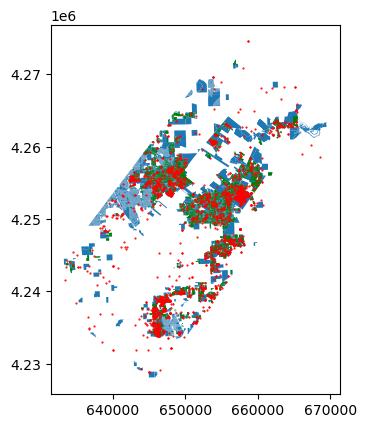

In [28]:
fig,ax= plt.subplots()
lu_res.plot(ax=ax)
lu_rural.plot(ax=ax,color='green')
domestic_pts.plot(ax=ax, markersize=0.3, color='red')

In [29]:
lu_rural.shape[0]/domestic_pts.shape[0]
# using parcels nearly triples the number of ag-res which is what we expected

2.7779495105615664

In [72]:
# calculate area of the parcel
lu_rural['area_m2'] = lu_rural.geometry.area.copy()
lu_rural['area_acres'] = lu_rural.area_m2*(1/0.3048**2)/43560
# each ag-residential parcel should sum on annual scale to 2AF, with a minimum daily value of 150 gpd
# join to model grid by the centroid of the parcel
lu_rural_out = lu_rural[['LU_SPECIF','LU_DETAIL', 'CITY','area_m2','area_acres', 'geometry']]
# spatial join with WCR points to keep information on well age and depth
lu_rural_out = gpd.sjoin(lu_rural_out,
                         domestic_pts[['WCRNumber','depth_m','geometry']], 
                         how='left').drop(columns=['index_right'])
# join parcels to the model grid assuming the well is in the centroid of the parcel
lu_rural_out.geometry = lu_rural_out.geometry.centroid
# rural_grid = gpd.sjoin(lu_rural_out, grid_p).drop(columns='index_right')
rural_grid = gpd.sjoin(grid_p, lu_rural_out).drop(columns='index_right')
# drop extra large parcels that shouldn't be considered residential, 20+ acres
rural_grid = rural_grid[rural_grid.area_acres < rural_grid.area_acres.quantile(0.99)]

C:\Users\andrewc\Anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Groupby parcels into area categories based on calculated area. By irrigating, it more generally means that water usage is scaled to property size.
- 0-1.5 acres, at minimum each parcel should use about 2AF/year, so any p
- 1.5-5, assume landowners are irrigating 80% of their parcel
- 5-10 assume landowners are irrigating 60% of their parcel
- 10-20 assume landowners are irrigating 40% of their parcel

In [93]:
rural_grid['usage_scale'] = 1/rural_grid.area_acres # default is 1 for area less than 1.5 acres
rural_grid.loc[rural_grid.area_acres>1.5,'usage_scale'] = 0.8
rural_grid.loc[rural_grid.area_acres>5,'usage_scale'] = 0.6
rural_grid.loc[rural_grid.area_acres>10,'usage_scale'] = 0.4
# calculated scaled area
rural_grid['used_area_acres'] = rural_grid.usage_scale * rural_grid.area_acres


In [95]:
rural_grid.used_area_acres.sum()

15887.25459150927

<Axes: >

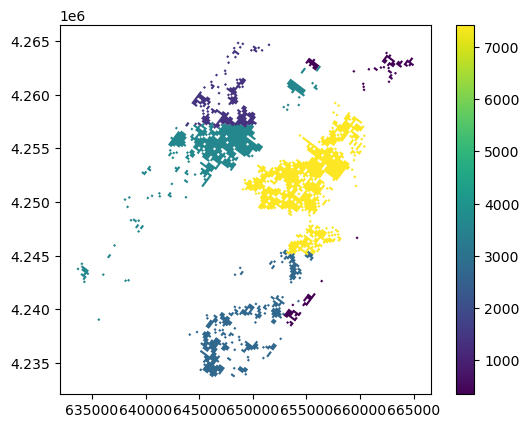

In [94]:
rural_grid.dissolve('CITY', aggfunc='sum').plot('used_area_acres', legend=True)

In [96]:
# fill in depth of wells based on interpolated domestic well depths
rural_grid['fill_depth_m'] = domestic_well_depth_arr[rural_grid.row-1, rural_grid.column-1]
rural_grid.loc[~rural_grid.depth_m.isna(),'fill_depth_m'] = rural_grid.loc[~rural_grid.depth_m.isna(), 'fill_depth_m']

In [97]:
rural_grid.drop(columns=['geometry']).to_csv(join(wel_dir, 'ag_res_parcel_domestic_wells.csv'))

# Calculate water use time-series
Assume baseline water usage for an ag-residential parcel of 1 acre is 2AF per year with a minimum daily usage of 50 gpd per capita with 3 people per parcel and the remaining daily water usage scaled by the ETc.

In [20]:
import h5py
nrow_p, ncol_p = (100,230)
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

In [21]:
strt_date = pd.to_datetime('1998-10-01')
end_date = pd.to_datetime('2020-9-30')

In [22]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc = agETc + natETc

KeyboardInterrupt: 

In [ ]:
years = pd.date_range(strt_date, end_date+pd.DateOffset(days=1), freq='AS-Oct')
year_ind = (years-strt_date).days

In [ ]:
# take average daily ET across the domain to use for scaling the domestic use
mean_ETc = agETc.mean(axis=(1,2))
scaled_ETc = mean_ETc.copy()
# group ET on an annual scale to determine the contribution each day makes to the year
for n in np.arange(0, len(years)-1):
    yr_scaled = mean_ETc[year_ind[n]:year_ind[n+1]]/mean_ETc[year_ind[n]:year_ind[n+1]].sum()
    scaled_ETc[year_ind[n]:year_ind[n+1]] = yr_scaled

In [ ]:
# the average minimum daily pumping in a single family household is 50 gpd for ~3 people (0.16 AF/yr)
min_pump = 150*(1/7.48)*(0.3048**3)
# typical max usage is 2AF/year for domestic
annual_domestic_irr = 2*43560*(0.3048**3) - min_pump*365
# the total annual pumping is downscaled to daily based on ET and minimum pumping is added back
domestic_use = scaled_ETc*annual_domestic_irr+min_pump


In [ ]:
plt.plot(domestic_use)

In [86]:
# save to output with dates as ID
dom_use_out = pd.DataFrame(domestic_use, columns=['flux_m3d'])
dom_use_out.index = pd.date_range(strt_date, end_date)
dom_use_out.to_csv(join(wel_dir, 'domestic_water_use.csv'))

In [75]:
# for n in np.arange(0, len(year_ind)-1):
#     print(domestic_use[year_ind[n]:year_ind[n+1]].sum()*(1/0.3048**3)/43560)